# **Import Libraries**

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import statsmodels.api as sm
from keras.utils import plot_model

# **Import Dataset**

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Load the dataset
demand_df = pd.read_csv('/content/drive/MyDrive/TUGAS/CAPSTONE/demand_data.csv')

In [21]:
demand_df.head()

,Date,Demand (kg)
0,January 2014,20481699.0
1,February 2014,21374931.0
2,March 2014,23005857.0
3,April 2014,23515279.0
4,May 2014,25569268.0


In [22]:
demand_df.tail()

,Date,Demand (kg)
118,November 2023,41971838.26
119,December 2023,41495945.12
120,January 2024,48327679.13
121,February 2024,52134303.45
122,March 2024,53282356.51


In [23]:
demand = demand_df['Demand (kg)']
print(demand)

0      20481699.00
1      21374931.00
2      23005857.00
3      23515279.00
4      25569268.00
          ...     
118    41971838.26
119    41495945.12
120    48327679.13
121    52134303.45
122    53282356.51
Name: Demand (kg), Length: 123, dtype: float64


Text(0.5, 1.0, 'Spices Demand')

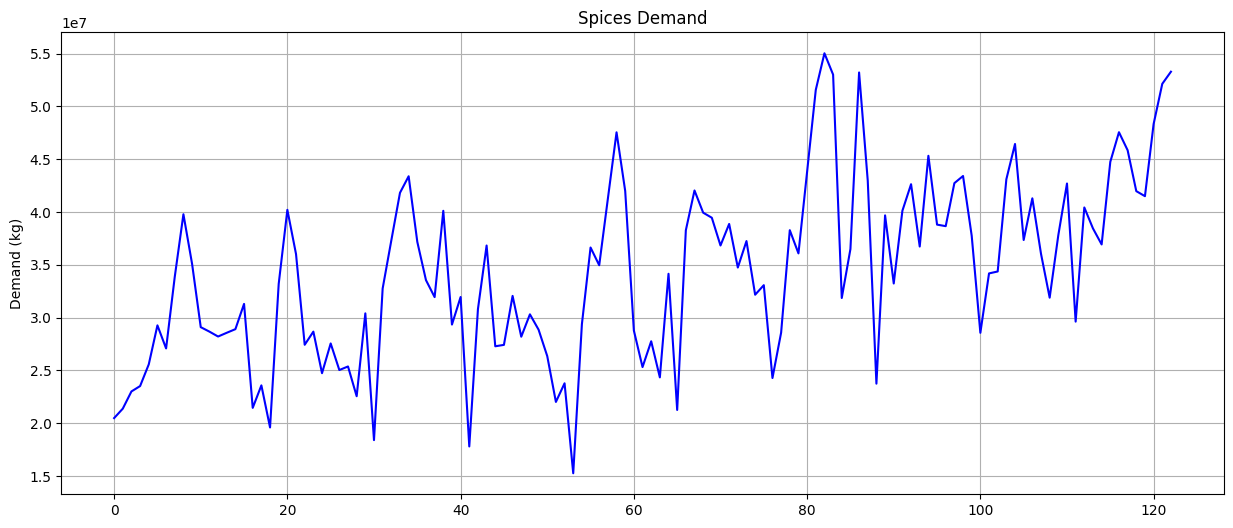

In [24]:
# Visualize the Data
plt.subplots(figsize = (15,6))
sns.lineplot(x=range(len(demand)), y=demand, color='blue')
plt.grid()
plt.title("Spices Demand")

# **Exploratory Data Analysis**

## Statistical Analysis

In [25]:
# Data Structure
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         123 non-null    object 
 1   Demand (kg)  123 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


Date change data type into datetime

In [26]:
# Duplication
print("Duplication sum: ", demand_df.duplicated().sum())

Duplication sum:  0


In [27]:
demand_df.describe(include='all')

,Date,Demand (kg)
count,123,1.230000e+02
unique,123,NaN
top,March 2024,NaN
freq,1,NaN
mean,NaN,3.432876e+07
std,NaN,8.501179e+06
min,NaN,1.525608e+07
25%,NaN,2.838192e+07
50%,NaN,3.418124e+07
75%,NaN,4.011336e+07


In [28]:
# Missing Value
demand_df.isnull().sum()

Date           0
Demand (kg)    0
dtype: int64

In [29]:
demand_df.shape

(123, 2)

There are 123 data (rows) with 2 columns

## Cleaning Data

In [30]:
# Fixing Data Type
datetime_columns = ["Date"]

for column in datetime_columns:
  demand_df[column] = pd.to_datetime(demand_df[column])

<ipython-input-30-a891e2f689ec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_df[column] = pd.to_datetime(demand_df[column])


In [31]:
#Recheck
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         123 non-null    datetime64[ns]
 1   Demand (kg)  123 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


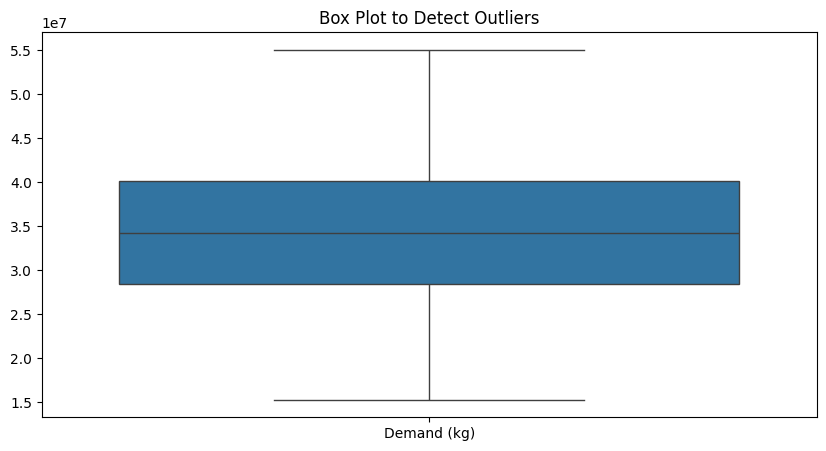

In [32]:
# Box plot to visualize outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=demand_df)
plt.title('Box Plot to Detect Outliers')
plt.show()

# **Define Functions**

## MinMax Scaling

In [33]:
def minmax(series):
  min = np.min(series)
  max = np.max(series)
  scaled = (series - min)/(max - min)
  return scaled, min, max

## Backtransform

In [34]:
def inverse_minmax(scaled_series, min, max):
  series = scaled_series*(max - min) + min
  return series

## Windowing

In [35]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [36]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Split the sequence into input-output pairs
    X, y = split_sequence(series, window_size, 1)  # Assuming n_steps_out is 1

    # Create a TF Dataset from the input-output pairs
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

## Verification

In [38]:
def verification(dataset, n_steps_in, n_lead_time, model):
  x_roll, y_roll = split_sequence(np.asarray(dataset), n_steps_in, n_steps_out)
  n = len(x_roll)-n_lead_time-1
  forecast_array = []
  actual_array = []

  for i in range(n):
    x = x_roll[i].reshape((1, n_steps_in, n_features))
    forecast = multi_step_forecasts(n_steps_in, n_lead_time, model, x)
    actual = y_roll[i:i+n_lead_time]
    forecast_array.append(forecast)
    actual_array.append(actual)

  forecast_array = np.array(forecast_array)
  actual_array = np.array(actual_array)

  df = pd.DataFrame(columns=['Lead Time no.', 'RMSE', 'MAPE', 'Pearson\'s Corr', 'R-Squared'])
  df['Lead Time no.'] = [i for i in range(1, n_lead_time + 1)]
  rmse = []
  mape = []
  corr = []
  rsq = []
  for j in range(n_lead_time):
    act_array = [actual_array[:,j][i][0] for i in range(len(actual_array[:,j]))]
    rmse.append(mean_squared_error(forecast_array[:,j], act_array, squared=False))
    mape.append(mean_absolute_percentage_error(forecast_array[:,j], act_array)*100)
    pearsonr_val, _ = pearsonr(forecast_array[:,j], act_array)
    corr.append(pearsonr_val)
    rsq.append(pearsonr_val**2)

  df['RMSE'] = rmse
  df['MAPE'] = mape
  df['Pearson\'s Corr'] = corr
  df['R-Squared'] = rsq

  return df

## Multi-Step Forecast

In [39]:
def multi_step_forecasts(n_steps_in, n_forecast, model, data):

    x_forecast = data  # last observed input sequence

    y_future = []     # predicted target values

    for i in range(n_forecast):
        # generate the next forecast
        output = model.predict(x_forecast, verbose = 0)

        # save the forecast
        y_future.append(output[0][0])

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_steps_in:].reshape(1, n_steps_in, 1)

        x_forecast = x_forecast.reshape(x_forecast.shape[0], n_steps_in, 1)  # last observed input sequence

    return y_future

# **Pre-Processing Data**

## Scaling Data

In [40]:
scaled, min_value, max_value = minmax(demand)
scaled.describe()

count    123.000000
mean       0.479563
std        0.213754
min        0.000000
25%        0.330036
50%        0.475854
75%        0.625011
max        1.000000
Name: Demand (kg), dtype: float64

Scaling data using Minmax Value, so the data will change between range 0 to 1

Text(0.5, 1.0, 'Spices Demand')

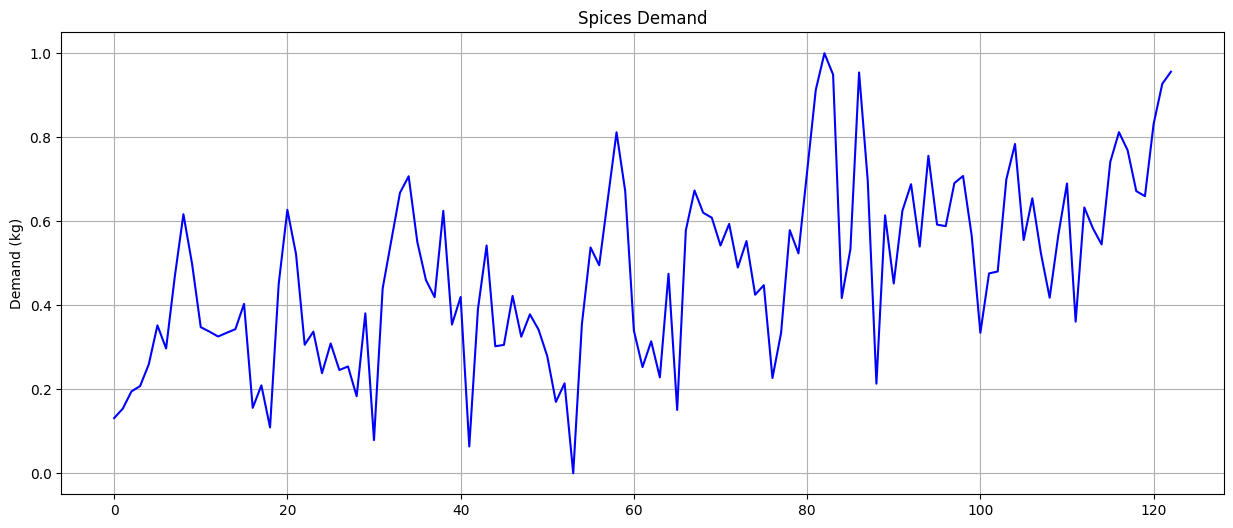

In [41]:
# Visualization of the scaled data
plt.subplots(figsize = (15,6))
sns.lineplot(x=range(len(scaled)), y=scaled, color='blue')

plt.grid()
plt.title("Spices Demand")

## Sequence to Supervised

In [42]:
# choose a number of time steps
n_steps_in, n_steps_out = 6, 1
# split into samples
X, y = split_sequence(scaled, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[0.13139299 0.15385241 0.1948604  0.2076693  0.25931477 0.35219101] [0.2972515]
[0.15385241 0.1948604  0.2076693  0.25931477 0.35219101 0.2972515 ] [0.46770423]
[0.1948604  0.2076693  0.25931477 0.35219101 0.2972515  0.46770423] [0.61674264]
[0.2076693  0.25931477 0.35219101 0.2972515  0.46770423 0.61674264] [0.49860489]
[0.25931477 0.35219101 0.2972515  0.46770423 0.61674264 0.49860489] [0.34790555]
[0.35219101 0.2972515  0.46770423 0.61674264 0.49860489 0.34790555] [0.33728372]
[0.2972515  0.46770423 0.61674264 0.49860489 0.34790555 0.33728372] [0.32561027]
[0.46770423 0.61674264 0.49860489 0.34790555 0.33728372 0.32561027] [0.334519]
[0.61674264 0.49860489 0.34790555 0.33728372 0.32561027 0.334519  ] [0.3431284]
[0.49860489 0.34790555 0.33728372 0.32561027 0.334519   0.3431284 ] [0.40330965]
[0.34790555 0.33728372 0.32561027 0.334519   0.3431284  0.40330965] [0.155752]
[0.33728372 0.32561027 0.334519   0.3431284  0.40330965 0.155752  ] [0.20929465]
[0.32561027 0.334519   0.3431284  

## Split Data

In [43]:
split_train = int(math.floor(0.80*((len(scaled))/n_steps_in)) * n_steps_in)

In [44]:
n_features = 1
x_train = X[:split_train]
x_val_test = X[split_train:]
split_val = int(len(x_val_test)/2)
x_val = x_val_test[:split_val]
x_test = x_val_test[split_val:]
x_future = X[-1]

y_train = y[:split_train]
y_val_test = y[split_train:]
y_val = y_val_test[:split_val]
y_test = y_val_test[split_val:]

n_features = 1
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
X_val = x_val.reshape((x_val.shape[0], x_val.shape[1], n_features))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
X_future = x_future.reshape((1, n_steps_in, n_features))

In [45]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_future.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(96, 6, 1)
(10, 6, 1)
(11, 6, 1)
(1, 6, 1)
(96, 1)
(10, 1)
(11, 1)


Training Data = 96

Validation Data = 10

Testing Data = 11

## Build The Model

In [46]:
def add_noise(data, noise_level=0.1):
    noise = noise_level * np.random.randn(*data.shape)
    return data + noise

X_train_augmented = add_noise(X_train)
y_train_augmented = y_train.copy()

X_train_combined = np.vstack((X_train, X_train_augmented))
y_train_combined = np.hstack((y_train, y_train_augmented))

In [47]:
# define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[n_steps_in]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)  # Assuming you want to scale the output
])

model.compile(optimizer='SGD', loss=tf.keras.losses.Huber(), metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 6, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 6, 64)               │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

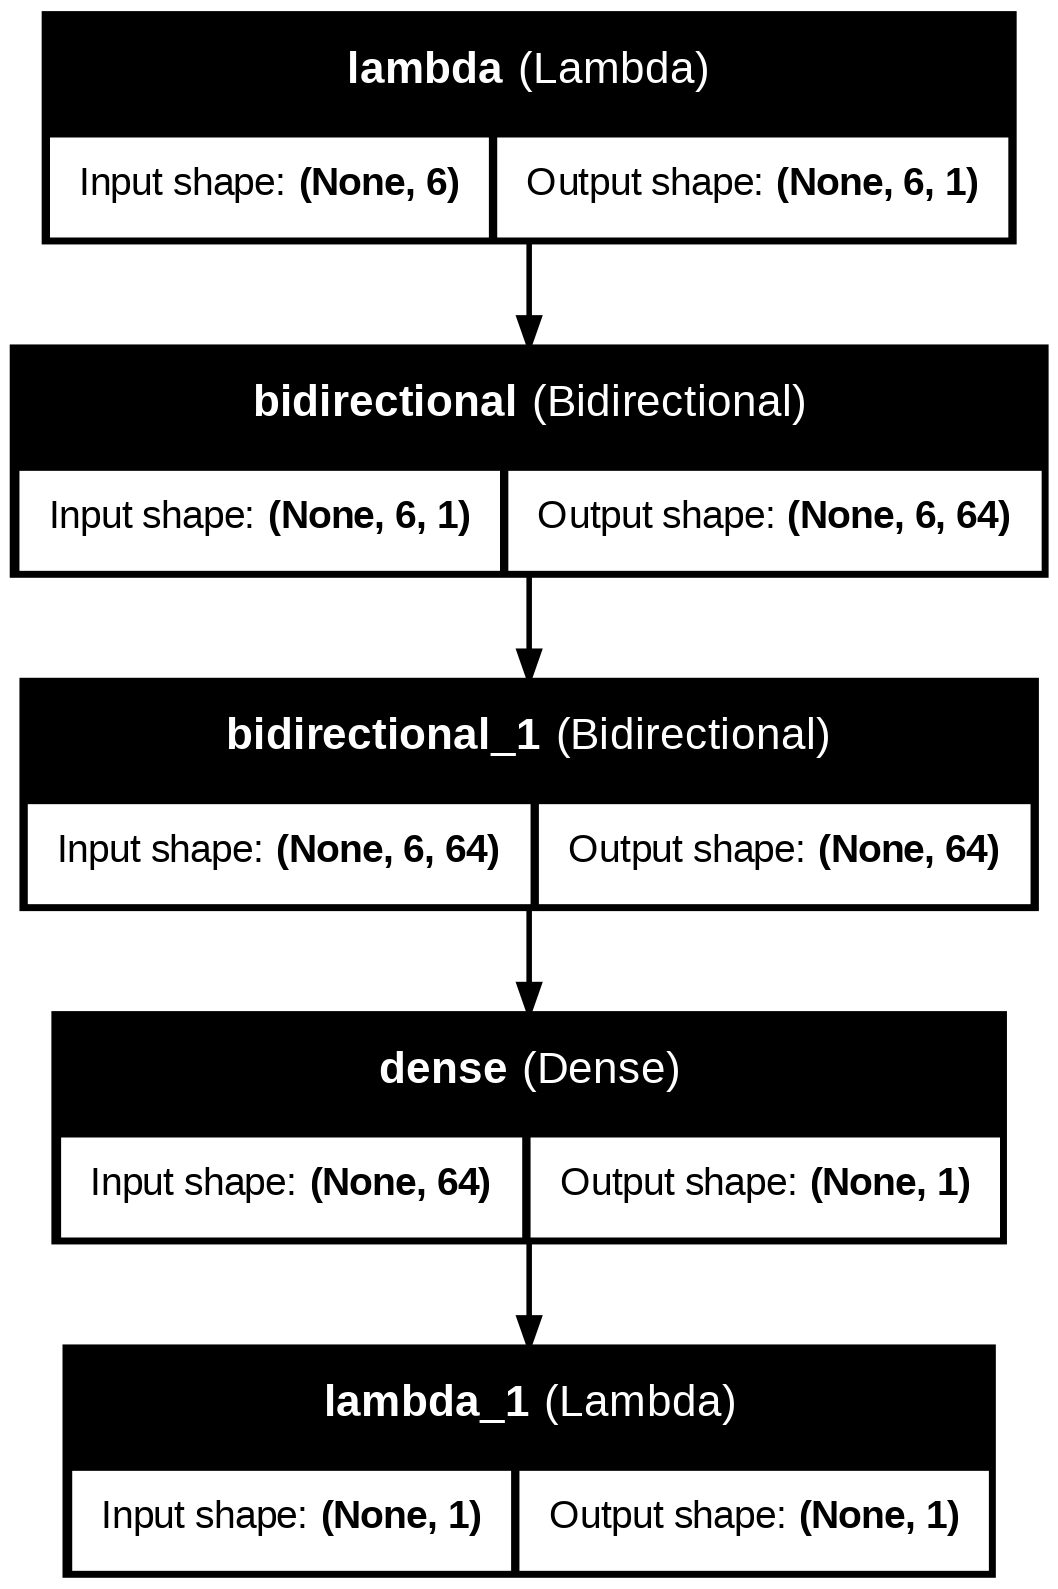

In [49]:
# Plot the Model
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## Tune The Learning Rate

## Training the Model

In [50]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[n_steps_in]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)  # Assuming you want to scale the output
])

# Set the optimizer
optimizer = 'adam'

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=500, verbose=1, validation_data = (X_val, y_val))

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 1.5126 - mae: 1.9874 - val_loss: 0.1613 - val_mae: 0.4895
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3392 - mae: 0.7452 - val_loss: 0.3177 - val_mae: 0.7428
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1961 - mae: 0.5298 - val_loss: 0.3477 - val_mae: 0.7955
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1658 - mae: 0.4921 - val_loss: 0.3368 - val_mae: 0.7769
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2058 - mae: 0.5415 - val_loss: 0.1105 - val_mae: 0.4052
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1157 - mae: 0.4234 - val_loss: 0.0347 - val_mae: 0.2157
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0445 - mae: 0.2393 - val_loss: 0.0788 - val_mae: 0.3289
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0586 - mae: 0.2891 - val_loss: 0.1034 - val_mae: 0.4067
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0589 - mae:

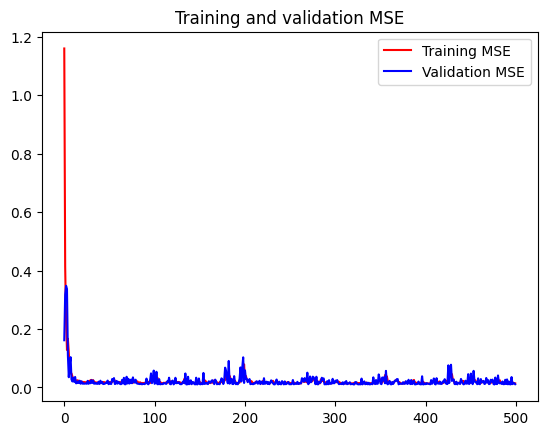

<Figure size 640x480 with 0 Axes>

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training MSE')
plt.plot(epochs, val_loss, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()

plt.show()

## Evaluation

### Training Data

In [52]:
forecast_train = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [53]:
frc_y_train = [forecast_train[i][0] for i in range(len(forecast_train))]

In [54]:
act_y_train = [y_train[i][0] for i in range(len(y_train))]

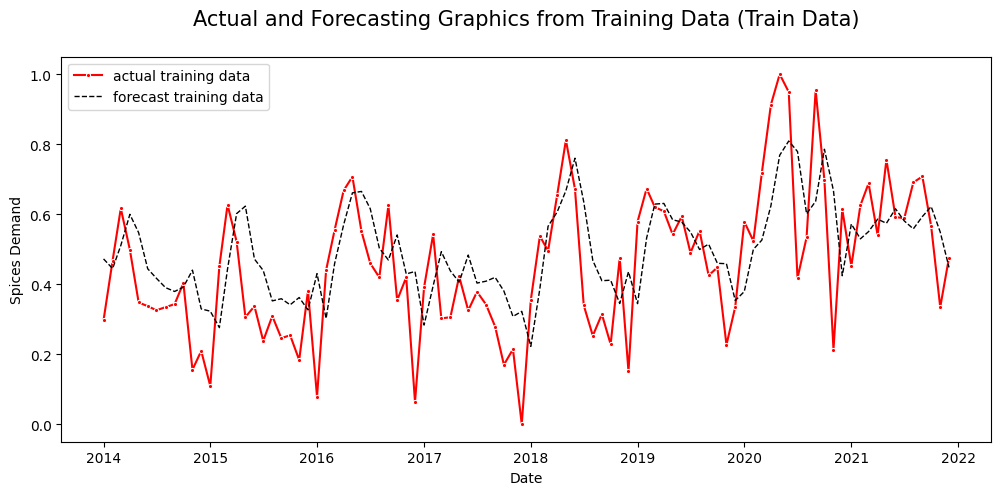

In [55]:
plt.subplots(figsize=(12, 5))
ax = sns.lineplot(x=demand_df["Date"][:split_train], y=act_y_train,
                    label="actual training data", marker='.', color = 'red')
ax = sns.lineplot(x=demand_df["Date"][:split_train], y=frc_y_train,
                    label="forecast training data", linestyle="--", color = 'black', lw = 1)
plt.xlabel('Date'); plt.ylabel('Spices Demand')
plt.title("Actual and Forecasting Graphics from Training Data (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [56]:
rmse = mean_squared_error(frc_y_train, act_y_train, squared=False)
mae = mean_absolute_error(frc_y_train, act_y_train)
mape = mean_absolute_percentage_error(frc_y_train, act_y_train)*100
coefficient_of_dermination = r2_score(frc_y_train, act_y_train)
corr, _ = pearsonr(frc_y_train, act_y_train)

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,4))
print('Correlation: ', round(corr,4))
print("Coefficient of Dermination: ", round(coefficient_of_dermination,4))

Forecast Train accuracy
RMSE:  0.1652
MAE:  0.1353
MAPE:  29.0714
Correlation:  0.6036
Coefficient of Dermination:  -0.7588


### Validation Data



In [57]:
forecast_val = model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


In [58]:
frc_y_val = [forecast_val[i][0] for i in range(len(forecast_val))]

In [59]:
act_y_val = [y_val[i][0] for i in range(len(y_val))]

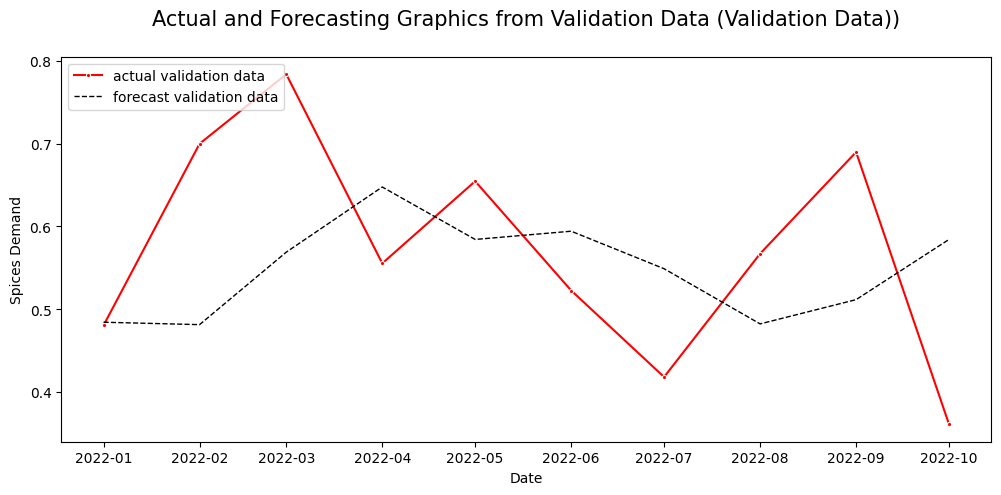

In [60]:
plt.subplots(figsize=(12, 5))
ax = sns.lineplot(x=demand_df["Date"][split_train:split_val+split_train], y=act_y_val,
                    label="actual validation data", marker='.', color = 'red')
ax = sns.lineplot(x=demand_df["Date"][split_train:split_val+split_train], y=frc_y_val,
                    label="forecast validation data", linestyle="--", color = 'black', lw = 1)
plt.xlabel('Date'); plt.ylabel('Spices Demand')
plt.title("Actual and Forecasting Graphics from Validation Data (Validation Data))\n", fontsize = 15)
plt.legend(loc='upper left')

In [61]:
rmse = mean_squared_error(frc_y_val, act_y_val, squared=False)
mae = mean_absolute_error(frc_y_val, act_y_val)
mape = mean_absolute_percentage_error(frc_y_val, act_y_val)*100
coefficient_of_dermination = r2_score(frc_y_val, act_y_val)
corr, _ = pearsonr(frc_y_val, act_y_val)

print('Forecast Validation accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,4))
print('Correlation: ', round(corr,4))
print("Coefficient of Dermination: ", round(coefficient_of_dermination,4))

Forecast Validation accuracy
RMSE:  0.1478
MAE:  0.1289
MAPE:  23.681
Correlation:  -0.1596
Coefficient of Dermination:  -6.4606


### Testing Data

In [62]:
forecast_test = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [63]:
frc_y_test = [forecast_test[i][0] for i in range(len(forecast_test))]

In [64]:
act_y_test = [y_test[i][0] for i in range(len(y_test))]

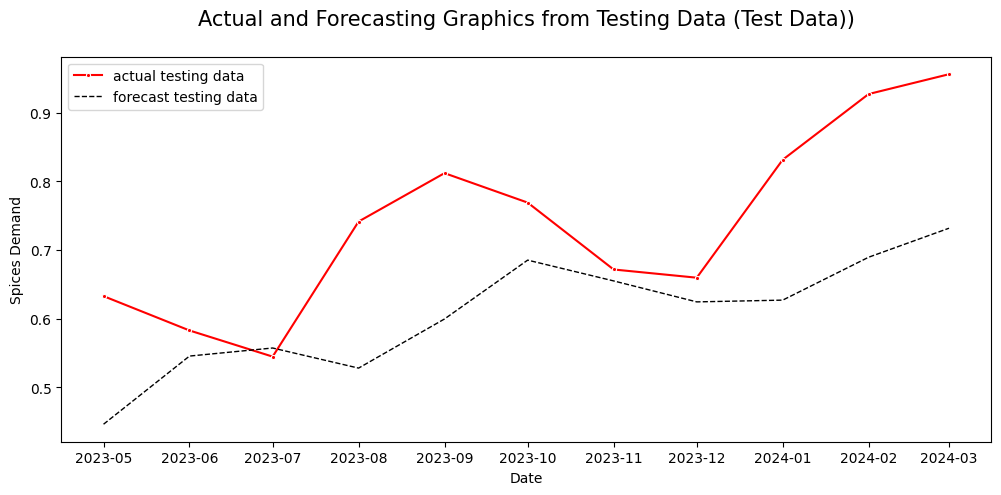

In [65]:
plt.subplots(figsize=(12, 5))
ax = sns.lineplot(x=demand_df["Date"][-11:], y=act_y_test,
                    label="actual testing data", marker='.', color = 'red')
ax = sns.lineplot(x=demand_df["Date"][-11:], y=frc_y_test,
                    label="forecast testing data", linestyle="--", color = 'black', lw = 1)
plt.xlabel('Date'); plt.ylabel('Spices Demand')
plt.title("Actual and Forecasting Graphics from Testing Data (Test Data))\n", fontsize = 15)
plt.legend(loc='upper left')

In [66]:
rmse = mean_squared_error(frc_y_test, act_y_test, squared=False)
mae = mean_absolute_error(frc_y_test, act_y_test)
mape = mean_absolute_percentage_error(frc_y_test, act_y_test)*100
coefficient_of_dermination = r2_score(frc_y_test, act_y_test)
corr, _ = pearsonr(frc_y_test, act_y_test)

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,4))
print('Correlation: ', round(corr,4))
print("Coefficient of Dermination: ", round(coefficient_of_dermination,4))

Forecast Test accuracy
RMSE:  0.1607
MAE:  0.1331
MAPE:  22.2579
Correlation:  0.6906
Coefficient of Dermination:  -3.067


# Model Deployment

## Save the Model

In [136]:
# Save the model in .h5 format
saved_model_path = "/content/drive/MyDrive/TUGAS/CAPSTONE/demand.h5"
model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Deployment using TF.js

In [8]:
!pip install tensorflowjs

In [9]:
# Define the path to the model and the output directory
input_path = '/content/drive/MyDrive/TUGAS/CAPSTONE/demand.h5'
output_path = '/content/drive/MyDrive/TUGAS/CAPSTONE/tfjs_model'

# Convert the model
!tensorflowjs_converter --input_format=keras {input_path} {output_path}

2024-05-31 15:15:33.159633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:15:34.176271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
import os
if os.path.exists("/content/drive/MyDrive/TUGAS/CAPSTONE/tfjs_model"):
    print("Conversion successful, demand.json found")
else:
    print("Conversion failed, demand.json not found")

Conversion successful, demand.json found


In [17]:
import shutil

# Define the name of the zip file
zip_path = '/content/drive/MyDrive/TUGAS/CAPSTONE/demand_tfjs.zip'

# Create a zip file
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', output_path)

print(f"Zip file created at: {zip_path}")

Zip file created at: /content/drive/MyDrive/TUGAS/CAPSTONE/demand_tfjs.zip


# Forecasting

In [70]:
real_forecast = multi_step_forecasts(6, 3, model, data = X_future)

In [71]:
real_forecast

[0.7318359, 0.663717, 0.64101636]

In [72]:
inverse_minmax(np.asarray(real_forecast), min_value, max_value)

array([44361876., 41652724., 40749896.], dtype=float32)